# Copyright Netherlands eScience Center <br>
**Function     : Testing BayesConvLSTM with Lorens-84 model** <br>
**Author       : Yang Liu** <br>
**First Built  : 2020.03.31** <br>
**Last Update  : 2020.05.08** <br>
**Library      : Pytorth, Numpy, NetCDF4, os, iris, cartopy, dlacs, matplotlib**<br>
Description     : This notebook serves to help understand the uncertainty generated by BayesConvLSTM with the sensitivity tests with Lorens 84 model. <br>

Three different types of uncertainties will vbe investigated here:<br>
- uncertainty of model outcome attributed to perturbation in initial conditions
- model uncertainty
- uncertainty related to extra/bias/trend terms

The Lorens-84 model is described by Edward Lorens in his 1984 paper:<br>
Lorenz, E. N. (1984). Irregularity: A fundamental property of the atmosphere. Tellus A, 36(2), 98-110.<br>

Return Values   : Time series and figures <br>

In [1]:
%matplotlib inline

import sys
import warnings
import numbers

# for data loading
import os
from netCDF4 import Dataset
# for pre-processing and machine learning
import numpy as np
import csv
import sklearn
#import scipy
import torch
import torch.nn.functional

#sys.path.append(os.path.join('C:','Users','nosta','ML4Climate','Scripts','DLACs'))
sys.path.append("C:\\Users\\nosta\\ML4Climate\\Scripts\\DLACs")
#sys.path.append("../")
import dlacs
import dlacs.BayesConvLSTM
import dlacs.preprocess
import dlacs.function
import dlacs.saveNetCDF
import dlacs.metric

# for visualization
import dlacs.visual
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm
from mpl_toolkits.mplot3d import Axes3D
import iris # also helps with regriding
import cartopy
import cartopy.crs as ccrs

# ignore all the DeprecationWarnings by pytorch
if not sys.warnoptions:
    warnings.simplefilter("ignore")
###############################################################################79

The testing device is Dell Inspirion 5680 with Intel Core i7-8700 x64 CPU and Nvidia GTX 1060 6GB GPU.<br>
Here is a benchmark about cpu v.s. gtx 1060 <br>
https://www.analyticsindiamag.com/deep-learning-tensorflow-benchmark-intel-i5-4210u-vs-geforce-nvidia-1060-6gb/

In [2]:
# constants
constant = {'g' : 9.80616,      # gravititional acceleration [m / s2]
            'R' : 6371009,      # radius of the earth [m]
            'cp': 1004.64,      # heat capacity of air [J/(Kg*K)]
            'Lv': 2500000,      # Latent heat of vaporization [J/Kg]
            'R_dry' : 286.9,    # gas constant of dry air [J/(kg*K)]
            'R_vap' : 461.5,    # gas constant for water vapour [J/(kg*K)]
            'rho' : 1026,       # sea water density [kg/m3]
            }

In [3]:
################################################################################# 
#########                           datapath                             ########
#################################################################################
# sensitivity test parameter
sense = 'x'
#sense = 'a'
#sense = 'G'
# model type
model_type = 'lorenz84ex' # choose lorenz84 or lorenz84ex
# datapath for output
output_path = 'C:\\Users\\nosta\\ML4Climate\\PredictArctic\\BayesMaps\\Lorenz84'
# data path of experiment
if sense == 'x':
    if model_type == 'lorenz84':
        #data_path = 'C:\\Users\\nosta\\ML4Climate\\PredictArctic\\BayesMaps\\Lorenz84\\x_002\\lorenz'
        data_path = 'C:\\Users\\nosta\\ML4Climate\\PredictArctic\\BayesMaps\\Lorenz84\\x_001\\lorenz'
        #data_path = 'C:\\Users\\nosta\\ML4Climate\\PredictArctic\\BayesMaps\\Lorenz84\\x_0001\\lorenz'
    elif model_type == 'lorenz84ex':
        #data_path = 'C:\\Users\\nosta\\ML4Climate\\PredictArctic\\BayesMaps\\Lorenz84\\x_001_ex\\lorenz'
        #data_path = 'C:\\Users\\nosta\\ML4Climate\\PredictArctic\\BayesMaps\\Lorenz84\\x_0001_ex\\lorenz'
        data_path = 'C:\\Users\\nosta\\ML4Climate\\PredictArctic\\BayesMaps\\Lorenz84\\x_00001_ex\\lorenz'
elif sense == 'a':
    if model_type == 'lorenz84':
        data_path = 'C:\\Users\\nosta\\ML4Climate\\PredictArctic\\BayesMaps\\Lorenz84\\a_0001\\lorenz'
    elif model_type == 'lorenz84ex':
        #data_path = 'C:\\Users\\nosta\\ML4Climate\\PredictArctic\\BayesMaps\\Lorenz84\\a_00001_ex\\lorenz'
        data_path = 'C:\\Users\\nosta\\ML4Climate\\PredictArctic\\BayesMaps\\Lorenz84\\a_000001_ex\\lorenz'
elif sense == 'G':
    if model_type == 'lorenz84':
        data_path = 'C:\\Users\\nosta\\ML4Climate\\PredictArctic\\BayesMaps\\Lorenz84\\G_001\\lorenz'
    elif model_type == 'lorenz84ex':
        #data_path = 'C:\\Users\\nosta\\ML4Climate\\PredictArctic\\BayesMaps\\Lorenz84\\G_0001_ex\\lorenz'
        data_path = 'C:\\Users\\nosta\\ML4Climate\\PredictArctic\\BayesMaps\\Lorenz84\\G_00001_ex\\lorenz'
else:
    raise IOError("The chosen variable is not supported for sensitivity experiment!")

# datapath of trained bayesconvlstm model
if model_type == 'lorenz84':
    bayesconvlstm_model_path = 'C:\\Users\\nosta\\ML4Climate\\PredictArctic\\BayesMaps\\Lorenz84\\bayes\\fullseries\\penalty100'
elif model_type == 'lorenz84ex':
    bayesconvlstm_model_path = 'C:\\Users\\nosta\\ML4Climate\\PredictArctic\\BayesMaps\\Lorenz84\\bayes\\fullseries_ex\\penalty100'
# datapath of forecast
if model_type == 'lorenz84':
    pred_lorenz_bayesconvlstm_path = 'C:\\Users\\nosta\\ML4Climate\\PredictArctic\\BayesMaps\\Lorenz84\\bayes\\fullseries\\penalty100'
elif model_type == 'lorenz84ex':
    pred_lorenz_bayesconvlstm_path = 'C:\\Users\\nosta\\ML4Climate\\PredictArctic\\BayesMaps\\Lorenz84\\bayes\\fullseries_ex\\penalty100'

#### Lorenz 84 model with periodic external forcing and its time scales<br>
##### Testing benchmark <br>
- Lorenz 84 model initial set-up <br>
**x=1.0, y=1.0, z=1.0, a=0.25, b=4.0, F=8.0, G=1.0, epsilon=0.4** <br>

##### Study the timescales of Lorenz 84 model and its influence on training and forecast
According to the theory of similarity, timesteps for seasonal and decadal timescales can be calculated based on the unit time scale of Lorenz 84 model, which is 5 day in this case. The relation is shown below:<br>
**1 timestep ~4 hours (1/30 5 day)** <br>

- 1 time unit = 30 timesteps ~ 5 days <br>
-------------------------------------------------------------------<br>
- 18 time unit = 540 timesteps ~ seasonal time scale (90 days) <br>
-------------------------------------------------------------------<br>
- 73 time unit = 2160 timesteps ~ annual time scale (365 days) <br>
-------------------------------------------------------------------<br>
- 730 time unit = 21600 timesteps ~ decadal time scale (3650 days) <br>

**Note that we count for time units rather than time steps since the system is too simple to compare with actual climate system, therefore we just need to keep the same ratio of unit timestep rather than to have "full cycles" according to the number of timesteps. In a nutshell, there is no real time in the system, only a dimensionless ratio.** <br>

In order to study the seasonal and decadal timescales, we take 2920 steps in total and take the last 730 steps as testing data. <br>

In [4]:
if __name__=="__main__":
    #################################################################################
    ###########                configure Lorenz 84 model                  ###########
    #################################################################################
    # name the ensemble member
    ens_num = 0
    # Lorenz paramters and initial conditions
    x_init = 1.0 # strength of the symmetric globally encircling westerly current
    y_init = 1.0 # strength of the cosine phases of a chain of superposedwaves (large scale eddies)
    z_init = 1.0 # strength of the sine phases of a chain of superposedwaves (large scale eddies)
    F = 8.0 # temperature difference between pole and equator
    G = 1.0 # thermal forcing term
    epsilon = 0.4 # intensity of periodic forcing
    a = 0.25 # mechanical damping factor for westerly wind x
    b = 4.0 # advection strength of the waves by the westerly current
    
    # assuming the damping time for the waves is 5 days (Lorens 1984)
    dt = 0.0333 # 1/30 unit of time unit (5 days)
    num_steps = 2920
    # cut-off point of initialization period
    cut_off = 0
    # target testing period
    test_len = 730

#### Ensemble<br>
##### Testing benchmark <br>
- Lorenz 84 model initial set-up <br>
**x=1.0, y=1.0, z=1.0, a=0.25, b=4.0, F=8.0, G=1.0** <br>
**x=1.0, y=1.0, z=1.0, a=0.25, b=4.0, F=8.0, G=1.0, epsilon=0.4** <br>

##### Testing 
- Testing initial conditions x, y, z - uncertainty of model outcome <br>
**starting point x=1.0, y=1.0, z=1.0** <br>
Ensemble variant x 50 members <br>
x = [1.0020 : 0.9980] **~0.2%**<br>
x = [1.0010 : 0.9990] **~0.1%**<br>
x = [1.00010 : 0.99990] **~0.01%**<br>
x_ex = [1.0010 : 0.9990] **~0.1%**<br>
x_ex = [1.00010 : 0.99990] **~0.01%**<br>
x_ex = [1.000010 : 0.999990] **~0.001%**<br>
========================================================================================================<br>
- Testing model parameters a & b - model uncertainty <br>
**starting point a=0.25, b=4.0** <br>
Ensemble variant a <br>
a = [0.25010 : 0.24990] **~0.04%**<br>
a_ex = [0.250010 : 0.249990] **~0.004%**<br>
a_ex = [0.2500010 : 0.2499990] **~0.0004%**<br>
========================================================================================================<br>
- Testing external forcing terms F & G - uncertainty related to extra/bias/trend terms <br>
**starting point F=8.0, G=1.0** <br>
Ensemble variant G <br>
G = [1.0010 : 0.9990] **~0.1%**<br>
G_ex = [1.00010 : 0.99990] **~0.01%**<br>
G_ex = [1.000010 : 0.999990] **~0.001%**<br>
**starting point F=8.0, G=1.0, epsilon=0.4** <br>

In [5]:
    #################################################################################
    ###########                     Lorens 84 model                       ###########
    #################################################################################    
    def lorenz84(x, y, z, a = 0.25, b = 4.0, F = 8.0, G = 1.0):
        """
        Solver of Lorens-84 model.
        param x, y, z: location in a 3D space
        param a, b, F, G: constants and forcing
        
        Physical interpretation:
        x represents the intensity of the symmetric globe-encircling westerly
        wind current, and also the poleward temperature gradient, which is assumed
        to be in permanent equilibrium with it.
        
        y and z represent the cosine and sine phases of a chain of superposed
        large-scale eddies, which transport heat poleward at a rate proportional
        to the square of their amplitude, and transport no angular momentum at all.
        (Lorenz identifies the eddies with Rossby waves!)
        
        xy and xz these nonlinear contributions represent amplification of the
        eddies through interaction with the westerly current
        
        -y**2 and -z**2 are the expense of the westerly current for the amplification
        of the eddies.
        
        -bxz and bxy represent displacement of the eddies by the westerly current.
        
        b allows the amplification (should be b>1.0)
        
        a represents mechanical and thermal damping(should be a>1.0).
        
        aF represents symmetric thermal forcing
        G represents asymmetric thermal forcing
        
        !@#$%^&* The variables have been scaled so that the coefficients are unity.
        
        Freire, J. G., Bonatto, C., DaCamara, C. C., & Gallas, J. A. (2008).
        Multistability, phase diagrams, and intransitivity in the Lorenz-84
        low-order atmospheric circulation model. Chaos: An Interdisciplinary
        Journal of Nonlinear Science, 18(3), 033121.
        """
        dx = - y**2 - z**2 - a * x + a * F
        dy = x * y - b * x * z - y + G
        dz = b * x * y + x * z - z
        
        return dx, dy, dz
    
    #################################################################################
    ###########            Lorens 84 model + periodic forcing             ###########
    #################################################################################
    def lorenz84_ex(x, y, z, t, a = 0.25, b = 4.0, F = 8.0, G = 1.0, epsilon = 1.0):
        """
        Solver of Lorens-84 model with periodic external forcing.
        
        param x, y, z: location in a 3D space
        param a, b, F, G: constants and forcing
        
        The model is designed with a reference to the paper:
        Broer, H., Simó, C., & Vitolo, R. (2002). Bifurcations and strange
        attractors in the Lorenz-84 climate model with seasonal forcing. Nonlinearity, 15(4), 1205.
        
        Song, Y., Yu, Y., & Wang, H. (2011, October). The stability and chaos analysis of the
        Lorenz-84 atmosphere model with seasonal forcing. In 2011 Fourth International Workshop
        on Chaos-Fractals Theories and Applications (pp. 37-41). IEEE.
        """
        # each time step is ~ 5days, therefore the returning period are 365 / 5 = 73 times in a year
        T = 73
        omega = 2 * np.pi / T
        dx = - y**2 - z**2 - a * x + a * F * (1 + epsilon * np.cos(omega * t))
        dy = x * y - b * x * z - y + G * (1 + epsilon * np.sin(omega * t))
        dz = b * x * y + x * z - z
        
        return dx, dy, dz

In [6]:
    #################################################################################
    ###########                 Launch Lorenz 84 model                    ###########
    #################################################################################   
    # Need one more for the initial values
    x = np.empty(num_steps)
    y = np.empty(num_steps)
    z = np.empty(num_steps)
    
    # save initial values
    x[0] = x_init
    y[0] = y_init
    z[0] = z_init
    
    # Step through "time", calculating the partial derivatives at the current point
    # and using them to estimate the next point
    for i in range(num_steps-1):
        dx, dy, dz = lorenz84(x[i], y[i], z[i], a, b ,F, G)
        x[i + 1] = x[i] + (dx * dt)
        y[i + 1] = y[i] + (dy * dt)
        z[i + 1] = z[i] + (dz * dt)

In [6]:
    #################################################################################
    ###########        Launch Lorenz 84 model with periodic forcing       ###########
    #################################################################################   
    # Need one more for the initial values
    x = np.empty(num_steps)
    y = np.empty(num_steps)
    z = np.empty(num_steps)
    t = 0.0
    
    # save initial values
    x[0] = x_init
    y[0] = y_init
    z[0] = z_init
    
    # Step through "time", calculating the partial derivatives at the current point
    # and using them to estimate the next point
    for i in range(num_steps-1):
        dx, dy, dz = lorenz84_ex(x[i], y[i], z[i], t, a, b ,F, G, epsilon)
        x[i + 1] = x[i] + (dx * dt)
        y[i + 1] = y[i] + (dy * dt)
        z[i + 1] = z[i] + (dz * dt)
        t += dt

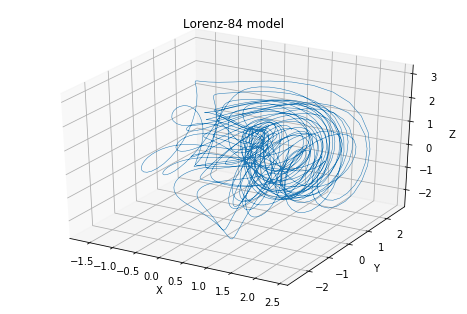

<Figure size 432x288 with 0 Axes>

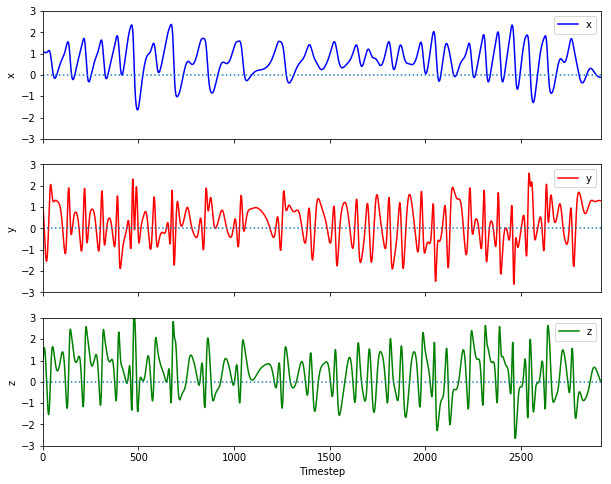

In [7]:
    #################################################################################
    ##########                 Visualize Lorens 84 model                   ##########
    #################################################################################   
    # save Lorens model output
    index = np.arange(num_steps)
    # Plot
    fig00 = plt.figure(figsize=(8,5.4))
    ax = fig00.gca(projection='3d')
    ax.plot(x, y, z, lw=0.5)
    ax.set_xlabel("X")
    ax.set_ylabel("Y")
    ax.set_zlabel("Z")
    ax.set_title("Lorenz-84 model")
    plt.show()
    if sense == 'x':
        fig00.savefig(os.path.join(output_path, 'lorenz84_3D_a{}_b{}_F{}_G{}_ens_{}.png'.format(a, b, F, G, ens_num)),dpi=150)
    elif sense == 'a':
        fig00.savefig(os.path.join(output_path, 'lorenz84_3D_x{}_b{}_F{}_G{}_ens_{}.png'.format(x_init, b, F, G, ens_num)),dpi=150)
    elif sense == 'G':
        fig00.savefig(os.path.join(output_path, 'lorenz84_3D_x{}_a{}_b{}_F{}_ens_{}.png'.format(x_init, a, b, F, ens_num)),dpi=150)
    else:
        raise IOError("The chosen variable is not supported for sensitivity experiment!")
        
    fig01 = plt.figure()
    fig01, (ax1,ax2,ax3) = plt.subplots(3, 1, sharex=True)
    fig01.set_size_inches(10, 8, forward=True)
    ax1.plot(index, x, 'b', label='x')
    ax2.plot(index, y, 'r', label='y')
    ax3.plot(index, z, 'g', label='z')
    
    ax1.axhline(y=0, ls = ':')
    ax2.axhline(y=0, ls = ':')
    ax3.axhline(y=0, ls = ':')
    
#     ax1.axvline(x=cut_off, ls = ':')
#     ax2.axvline(x=cut_off, ls = ':')
#     ax3.axvline(x=cut_off, ls = ':')
    
    ax1.set_xlim(0, num_steps)
    ax2.set_xlim(0, num_steps)
    ax3.set_xlim(0, num_steps)
    
    ax1.set_ylim(-3, 3)
    ax2.set_ylim(-3, 3)
    ax3.set_ylim(-3, 3)
    
    ax1.set_ylabel("x")
    ax2.set_ylabel("y")
    ax3.set_ylabel("z")
    
    plt.xlabel("Timestep")
    
    ax1.legend()
    ax2.legend()
    ax3.legend()

    plt.show()
    if sense == 'x':
        fig01.savefig(os.path.join(output_path, 'lorenz84_series_a{}_b{}_F{}_G{}_ens_{}.png'.format(a, b, F, G, ens_num)),dpi=150)
    elif sense == 'a':
        fig01.savefig(os.path.join(output_path, 'lorenz84_series_x{}_b{}_F{}_G{}_ens_{}.png'.format(x_init, b, F, G, ens_num)),dpi=150)
    elif sense == 'G':
        fig01.savefig(os.path.join(output_path, 'lorenz84_series_x{}_a{}_b{}_F{}_ens_{}.png'.format(x_init, a, b, F, ens_num)),dpi=150)
    else:
        raise IOError("The chosen variable is not supported for sensitivity experiment!")

In [18]:
    #################################################################################
    ##########           Low pass filter Lorens 84 model output            ##########
    #################################################################################
    # window size seasonal / decadal
    #win_size = 18
    win_size = 730
    
    stat_x = dlacs.preprocess.operator(x[:])
    stat_y = dlacs.preprocess.operator(y[:])
    stat_z = dlacs.preprocess.operator(z[:])
    
    xx = stat_x.lowpass(window=win_size, obj='original')
    yy = stat_y.lowpass(window=win_size, obj='original')
    zz = stat_z.lowpass(window=win_size, obj='original')

<Figure size 432x288 with 0 Axes>

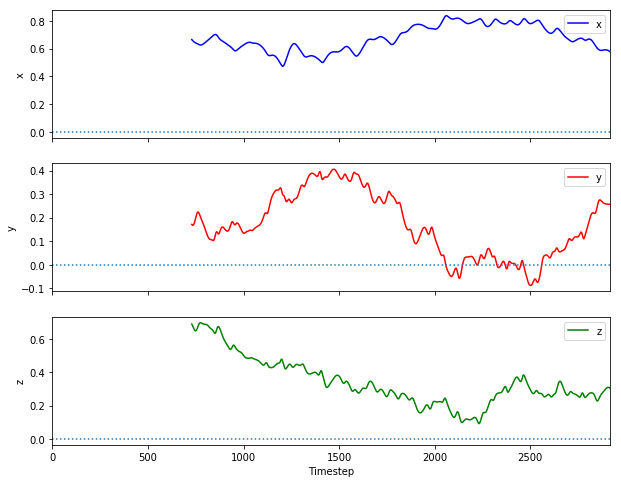

In [20]:
    #################################################################################
    ##########                 Visualize Lorens 84 model                   ##########
    #################################################################################   
    # save Lorens model output
    index = np.arange(num_steps)
    # Plot
    fig01 = plt.figure()
    fig01, (ax1,ax2,ax3) = plt.subplots(3, 1, sharex=True)
    fig01.set_size_inches(10, 8, forward=True)
    ax1.plot(index[win_size-1:], xx, 'b', label='x')
    ax2.plot(index[win_size-1:], yy, 'r', label='y')
    ax3.plot(index[win_size-1:], zz, 'g', label='z')
    
    ax1.axhline(y=0, ls = ':')
    ax2.axhline(y=0, ls = ':')
    ax3.axhline(y=0, ls = ':')
    
#     ax1.axvline(x=cut_off, ls = ':')
#     ax2.axvline(x=cut_off, ls = ':')
#     ax3.axvline(x=cut_off, ls = ':')
    
    ax1.set_xlim(0, num_steps)
    ax2.set_xlim(0, num_steps)
    ax3.set_xlim(0, num_steps)
    
#     ax1.set_ylim(-3, 3)
#     ax2.set_ylim(-3, 3)
#     ax3.set_ylim(-3, 3)
    
    ax1.set_ylabel("x")
    ax2.set_ylabel("y")
    ax3.set_ylabel("z")
    
    plt.xlabel("Timestep")
    
    ax1.legend()
    ax2.legend()
    ax3.legend()

    plt.show()
    if sense == 'x':
        fig01.savefig(os.path.join(output_path, 'lorenz84_series_a{}_b{}_F{}_G{}_lowpass_w{}.png'.format(a, b, F, G, win_size)),dpi=150)
    elif sense == 'a':
        fig01.savefig(os.path.join(output_path, 'lorenz84_series_x{}_b{}_F{}_G{}_lowpass_w{}.png'.format(x_init, b, F, G, win_size)),dpi=150)
    elif sense == 'G':
        fig01.savefig(os.path.join(output_path, 'lorenz84_series_x{}_a{}_b{}_F{}_lowpass_w{}.png'.format(x_init, a, b, F, win_size)),dpi=150)
    else:
        raise IOError("The chosen variable is not supported for sensitivity experiment!")

# Forecast with BayesConvLSTM <br>
** We use Pytorth to implement BayesConvLSTM neural network to deal with the Lorenz 84 model output. ** <br>

In [22]:
    print ('*******************  pre-processing  *********************')
    # time series cut-off
    if cut_off:
        xx = xx[cut_off:]
        yy = yy[cut_off:]
        zz = zz[cut_off:]
    print ('===================  normalize data  =====================')
    x_norm = dlacs.preprocess.operator.normalize(xx)
    y_norm = dlacs.preprocess.operator.normalize(yy)
    z_norm = dlacs.preprocess.operator.normalize(zz)
    print('================  save the normalizing factor  =================')
    x_max = np.amax(xx)
    x_min = np.amin(xx)
    y_max = np.amax(yy)
    y_min = np.amin(yy)
    z_max = np.amax(zz)
    z_min = np.amin(zz)

*******************  pre-processing  *********************
===================  normalize data  =====================
================  save the normalizing factor  =================


In [25]:
    print ('*******************  create basic dimensions for tensor and network  *********************')
    # specifications of neural network
    input_channels = 3
    #hidden_channels = [3, 2, 1] # number of channels & hidden layers, the channels of last layer is the channels of output, too
    hidden_channels = [3]
    kernel_size = 1
    # here we input a sequence and predict the next step only
    #step = 1 # how many steps to predict ahead
    #effective_step = [0] # step to output
    batch_size = 1
    #num_layers = 1
    learning_rate = 0.01
    num_epochs = 1500
    # check the sequence shape
    sequence_len = num_steps - win_size + 1 - cut_off
    height = 1
    width = 1
    print ('*******************  testing data  *********************')
    test_len = 730
    print ('*******************  check the environment  *********************')
    print ("Pytorch version {}".format(torch.__version__))
    # check if CUDA is available
    use_cuda = torch.cuda.is_available()
    print("Is CUDA available? {}".format(use_cuda))
    # CUDA settings torch.__version__ must > 0.4
    # !!! This is important for the model!!! The first option is gpu
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")   

*******************  create basic dimensions for tensor and network  *********************
*******************  testing data  *********************
*******************  check the environment  *********************
Pytorch version 1.1.0
Is CUDA available? True


In [9]:
    %%time
    print ('*******************  load exsited LSTM model  *********************')
    # load model parameters
    model = dlacs.BayesConvLSTM.BayesConvLSTM(input_channels, hidden_channels, kernel_size).to(device)
    model.load_state_dict(torch.load(os.path.join(bayesconvlstm_model_path, 'bayesconvlstm_lorenz84_fullseries_penalty100.pkl'),
                                     map_location=device))

*******************  load exsited LSTM model  *********************
!@#$% The network will be built with reduced size BayesConvLSTM cell. !@#$%
Wall time: 2.07 s


IncompatibleKeys(missing_keys=[], unexpected_keys=[])

In [10]:
print(bayesconvlstm_model_path)

C:\Users\nosta\ML4Climate\PredictArctic\BayesMaps\Lorenz84\bayes\fullseries\penalty100


In [28]:
    print ('*******************  run BayesConvLSTM  *********************')
    print ('The model is designed to make many to one prediction.')
    print ('A series of multi-chanel variables will be input to the model.')
    print ('The model learns by verifying the output at each timestep.')
    # initialize our model
    model = dlacs.BayesConvLSTM.BayesConvLSTM(input_channels, hidden_channels, kernel_size).to(device)
    #model = dlacs.BayesConvLSTM.BayesConvLSTM(input_channels, hidden_channels,
    #                                          kernel_size, cell_type="full").to(device)    
    # use Evidence Lower Bound (ELBO) to quantify the loss
    ELBO = dlacs.function.ELBO(height*width)
    # penalty for kl
    penalty_kl = 100
    # stochastic gradient descent
    #optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)
    # Adam optimizer
    optimiser = torch.optim.Adam(model.parameters(), lr=learning_rate)
    print(model)
    print(ELBO)
    print(optimiser)

*******************  run BayesConvLSTM  *********************
The model is designed to make many to one prediction.
A series of multi-chanel variables will be input to the model.
The model learns by verifying the output at each timestep.
!@#$% The network will be built with reduced size BayesConvLSTM cell. !@#$%
BayesConvLSTM(
  (cell0): BayesConvLSTMCell()
)
ELBO(
  (loss_function): MSELoss()
)
Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 0.01
    weight_decay: 0
)


In [29]:
    for name, param in model.named_parameters():
        if param.requires_grad:
            print (name)
            print (param.data)
            print (param.size())
            print ("=========================")

cell0.Wxi_mu
tensor([[[[-0.1314]],

         [[ 0.3378]],

         [[-0.0333]]],


        [[[ 0.1920]],

         [[-0.5020]],

         [[-0.2563]]],


        [[[ 0.3222]],

         [[-0.5664]],

         [[ 0.5089]]]], device='cuda:0')
torch.Size([3, 3, 1, 1])
cell0.Whi_mu
tensor([[[[ 0.3717]],

         [[-0.0809]],

         [[ 0.0248]]],


        [[[ 0.2453]],

         [[ 0.3038]],

         [[-0.0789]]],


        [[[ 0.3959]],

         [[-0.2338]],

         [[ 0.2044]]]], device='cuda:0')
torch.Size([3, 3, 1, 1])
cell0.Wxf_mu
tensor([[[[-0.2900]],

         [[-0.2093]],

         [[-0.0089]]],


        [[[-0.5367]],

         [[ 0.5458]],

         [[ 0.4354]]],


        [[[-0.5630]],

         [[-0.2081]],

         [[ 0.0485]]]], device='cuda:0')
torch.Size([3, 3, 1, 1])
cell0.Whf_mu
tensor([[[[ 0.0970]],

         [[-0.0987]],

         [[-0.3554]]],


        [[[-0.0995]],

         [[-0.3171]],

         [[-0.4874]]],


        [[[ 0.3260]],

         [[-0.3714]],

In [11]:
    print('##############################################################')
    print('#############  preview model parameters matrix  ###############')
    print('##############################################################')
    print('Number of parameter matrices: ', len(list(model.parameters())))
    for i in range(len(list(model.parameters()))):
        print(list(model.parameters())[i].size())

##############################################################
#############  preview model parameters matrix  ###############
##############################################################
Number of parameter matrices:  20
torch.Size([3, 3, 1, 1])
torch.Size([3, 3, 1, 1])
torch.Size([3, 3, 1, 1])
torch.Size([3, 3, 1, 1])
torch.Size([3, 3, 1, 1])
torch.Size([3, 3, 1, 1])
torch.Size([3, 3, 1, 1])
torch.Size([3, 3, 1, 1])
torch.Size([3])
torch.Size([3])
torch.Size([3])
torch.Size([3])
torch.Size([1, 1])
torch.Size([1, 1])
torch.Size([1, 1])
torch.Size([1, 1])
torch.Size([1, 1])
torch.Size([1, 1])
torch.Size([1, 1])
torch.Size([1, 1])


In [40]:
    %%time
    print('##############################################################')
    print('##################  start training loop  #####################')
    print('##############################################################')
    # track training loss
    hist = np.zeros(num_epochs)
    hist_likelihood = np.zeros(num_epochs)
    hist_complexity = np.zeros(num_epochs)
    # loop of epoch
    for t in range(num_epochs):
        # Clear stored gradient
        model.zero_grad()
        # loop of timestep
        for timestep in range(sequence_len - test_len):
            # hidden state re-initialized inside the model when timestep=0
            #################################################################################
            ########          create input tensor with multi-input dimension         ########
            #################################################################################
            # create variables
            x_input = np.stack((x_norm[timestep], y_norm[timestep], z_norm[timestep])) #vstack,hstack,dstack
            x_var = torch.autograd.Variable(torch.Tensor(x_input).view(-1,input_channels,height,width)).to(device)
            #################################################################################
            ########       create training tensor with multi-input dimension         ########
            #################################################################################
            y_train_stack = np.stack((x_norm[timestep+1], y_norm[timestep+1], z_norm[timestep+1])) #vstack,hstack,dstack
            y_var = torch.autograd.Variable(torch.Tensor(y_train_stack).view(-1,hidden_channels[-1],height,width)).to(device)
            #################################################################################   
            # Forward pass
            y_pred, kl_loss, _ = model(x_var, timestep)
            # choose training data
            y_target = y_var
            # torch.nn.functional.mse_loss(y_pred, y_train) can work with (scalar,vector) & (vector,vector)
            # Please Make Sure y_pred & y_train have the same dimension
            # accumulate loss
            if timestep == 0:
                loss, likelihood, complexity = ELBO(y_pred, y_target, kl_loss,
                                                    1 / (len(hidden_channels) * 8 * penalty_kl * kernel_size**2))
            else:
                loss_step, likelihood_step,\
                complexity_step = ELBO(y_pred, y_target, kl_loss,
                                       1 / (len(hidden_channels) * 8 * penalty_kl * kernel_size**2))
                loss += loss_step
                likelihood += likelihood_step
                complexity += complexity_step           
        #print(y_pred.shape)
        #print(y_train.shape)
        # print loss at certain iteration
        if t % 5 == 0:
            print("Epoch {} ELBO: {:0.3f}".format(t, loss.item()))
            print("likelihood cost {:0.3f} #*# complexity cost {:0.3f}".format(likelihood.item(), complexity.item()))
            # gradient check
            # Gradcheck requires double precision numbers to run
            #res = torch.autograd.gradcheck(loss_fn, (y_pred.double(), y_train.double()), eps=1e-6, raise_exception=True)
            #print(res)
        hist[t] = loss.item()
        hist_likelihood[t] = likelihood.item()
        hist_complexity[t] = complexity.item()

        # Zero out gradient, else they will accumulate between epochs
        optimiser.zero_grad()
    
        # Backward pass
        loss.backward()

        # Update parametersdd
        optimiser.step()
        
    # save the model
    # (recommended) save the model parameters only
    torch.save(model.state_dict(), os.path.join(output_path,'bayesconvlstm_lorenz84.pkl'))
    # save the entire model
    # torch.save(model, os.path.join(output_path,'bayesconvlstm.pkl'))

##############################################################
##################  start training loop  #####################
##############################################################
Epoch 0 ELBO: 543.868
likelihood cost 504.674 #*# complexity cost 39.194
Epoch 5 ELBO: 429.907
likelihood cost 393.024 #*# complexity cost 36.884
Epoch 10 ELBO: 327.335
likelihood cost 290.213 #*# complexity cost 37.123
Epoch 15 ELBO: 252.390
likelihood cost 213.048 #*# complexity cost 39.342
Epoch 20 ELBO: 211.729
likelihood cost 168.996 #*# complexity cost 42.733
Epoch 25 ELBO: 199.721
likelihood cost 154.909 #*# complexity cost 44.812
Epoch 30 ELBO: 183.605
likelihood cost 139.814 #*# complexity cost 43.791
Epoch 35 ELBO: 163.917
likelihood cost 122.984 #*# complexity cost 40.932
Epoch 40 ELBO: 147.995
likelihood cost 110.480 #*# complexity cost 37.514
Epoch 45 ELBO: 138.156
likelihood cost 103.157 #*# complexity cost 34.998
Epoch 50 ELBO: 128.491
likelihood cost 95.180 #*# complexity cost 33.312


KeyboardInterrupt: 

*******************  Loss with time  **********************
*******************  Loss with time (log)  **********************


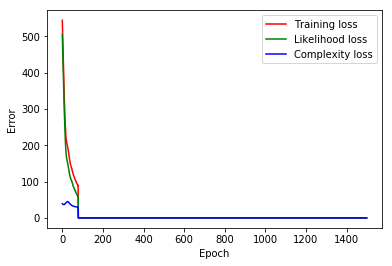

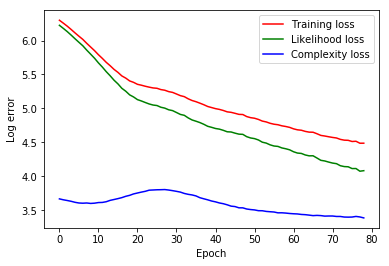

In [41]:
    print ("*******************  Loss with time  **********************")
    fig00 = plt.figure()
    plt.plot(hist, 'r', label="Training loss")
    plt.plot(hist_likelihood, 'g', label="Likelihood loss")
    plt.plot(hist_complexity, 'b', label="Complexity loss")
    plt.xlabel('Epoch')
    plt.ylabel('Error')
    plt.legend()
    #fig00.savefig(os.path.join(output_path,'BayesConvLSTM_pred_error_Lorenz84.png'),dpi=150)
    
    print ("*******************  Loss with time (log)  **********************")
    fig01 = plt.figure()
    plt.plot(np.log(hist), 'r', label="Training loss")
    plt.plot(np.log(hist_likelihood), 'g', label="Likelihood loss")
    plt.plot(np.log(hist_complexity), 'b', label="Complexity loss")
    plt.xlabel('Epoch')
    plt.ylabel('Log error')
    plt.legend()
    plt.show()
    #fig01.savefig(os.path.join(output_path,'BayesConvLSTM_pred_log_error_Lorenz84.png'),dpi=150)

# Forecast <br>
**Forecast loop and ensemble generation.** <br>

In [11]:
    %%time
    #################################################################################
    ########  operational lead time dependent prediction with testing data   ########
    #################################################################################
    print('##############################################################')
    print('###################  start prediction loop ###################')
    print('##############################################################')
    # the model learn from time series and try to predict the next time step based on the previous time series
    print ('*******************************  one step ahead forecast  *********************************')
    # time series before test data
    pred_base_x = x_norm[:-test_len]
    pred_base_y = y_norm[:-test_len]
    pred_base_z = z_norm[:-test_len]
    # predict x steps ahead
    step_lead = 16 # unit week
    # ensemble
    ensemble = 5
    # create a matrix for the prediction
    lead_pred_x = np.zeros((test_len,step_lead),dtype=float) # dim [predict time, lead time，lat, lon]
    lead_pred_y = np.zeros((test_len,step_lead),dtype=float) # dim [predict time, lead time，lat, lon]
    lead_pred_z = np.zeros((test_len,step_lead),dtype=float) # dim [predict time, lead time，lat, lon]
    # start the prediction loop
    for ens in range(ensemble):
        print('ensemble No. {}'.format(ens))
        ncKey = dlacs.saveNetCDF.savenc(output_path, 'pred_lorenz84_ens_{}.nc'.format(ens))
        lead_pred_xyz = np.zeros((3, test_len, step_lead), dtype=float)
        for step in range(test_len):
            # Clear stored gradient
            model.zero_grad()
            # Don't do this if you want your LSTM to be stateful
            # Otherwise the hidden state should be cleaned up at each time step for prediction (we don't clear hidden state in our forward function)
            # see example from (https://github.com/pytorch/examples/blob/master/time_sequence_prediction/train.py)
            # model.hidden = model.init_hidden()
            # based on the design of this module, the hidden states and cell states are initialized when the module is called.
            for i in np.arange(1,sequence_len - test_len + step + step_lead, 1): # here i is actually the time step (index) of prediction, we use var[:i] to predict var[i]
                #############################################################################
                ###############           before time of prediction           ###############
                #############################################################################
                if i <= (sequence_len - test_len + step):
                    # create variables
                    x_input = np.stack((x_norm[i-1], y_norm[i-1], z_norm[i-1])) #vstack,hstack,dstack
                    x_var_pred = torch.autograd.Variable(torch.Tensor(x_input).view(-1,input_channels,height,width),
                                                         requires_grad=False).to(device)
                    # make prediction
                    last_pred, _, _ = model(x_var_pred, i-1, training=False)
                    # record the real prediction after the time of prediction
                    if i == (sequence_len - test_len + step):
                        lead = 0
                        # GPU data should be transferred to CPU
                        lead_pred_x[step,0] = last_pred[0,0].cpu().data.numpy()
                        lead_pred_y[step,0] = last_pred[0,1].cpu().data.numpy()
                        lead_pred_z[step,0] = last_pred[0,2].cpu().data.numpy()
                #############################################################################
                ###############            after time of prediction           ###############
                #############################################################################
                else:
                    lead += 1
                    # use the predicted data to make new prediction
                    x_input = np.stack((lead_pred_x[step,i-(sequence_len - test_len + step +1)],
                                        lead_pred_y[step,i-(sequence_len - test_len + step +1)],
                                        lead_pred_z[step,i-(sequence_len - test_len + step +1)])) #vstack,hstack,dstack
                    x_var_pred = torch.autograd.Variable(torch.Tensor(x_input).view(-1,input_channels,height,width),
                                                         requires_grad=False).to(device)
                    # make prediction
                    last_pred, _, _ = model(x_var_pred, i-1, training=False)
                    # record the prediction
                    lead_pred_x[step,lead] = last_pred[0,0].cpu().data.numpy()
                    lead_pred_y[step,lead] = last_pred[0,1].cpu().data.numpy()
                    lead_pred_z[step,lead] = last_pred[0,2].cpu().data.numpy()
        lead_pred_xyz[0,:,:] = lead_pred_x[:]
        lead_pred_xyz[1,:,:] = lead_pred_y[:]
        lead_pred_xyz[2,:,:] = lead_pred_z[:]
        ncKey.ncfile_Lorenz(lead_pred_xyz)

##############################################################
###################  start prediction loop ###################
##############################################################
*******************************  one step ahead forecast  *********************************
ensemble No. 0
Save output fields as netCDF4 files.
Create netcdf files successfully!!
ensemble No. 1
Save output fields as netCDF4 files.
Create netcdf files successfully!!
ensemble No. 2
Save output fields as netCDF4 files.
Create netcdf files successfully!!
ensemble No. 3
Save output fields as netCDF4 files.
Create netcdf files successfully!!
ensemble No. 4
Save output fields as netCDF4 files.
Create netcdf files successfully!!
Wall time: 2h 46min 13s


# Postprocess forecast data <br>
** Postprocess and visualization of ensemble forecast data ** <br>

In [10]:
    #######################################################################
    #######    Load forecast of Lorenz 84 model by BayesConvLSTM    #######
    #######################################################################
    print ('*******************  load ensemble data  *********************')
    # predict x steps ahead
    step_lead = 16 # unit week
    # number of ensembles
    ens = 20
    predictand = np.zeros((ens, 3, test_len, step_lead), dtype=float)
    for i in range(ens):
        dataset_pred = Dataset(os.path.join(pred_lorenz_bayesconvlstm_path,
                                            'pred_lorenz84_ens_{}.nc'.format(i)))
        predictand[i,:,:,:] = dataset_pred.variables['series'][:]
    print(predictand.shape)
    predictand_median = np.median(predictand, 0)

*******************  load ensemble data  *********************
(20, 3, 200, 16)


===================  visualize data  =====================
===================    time series   =====================


<Figure size 432x288 with 0 Axes>

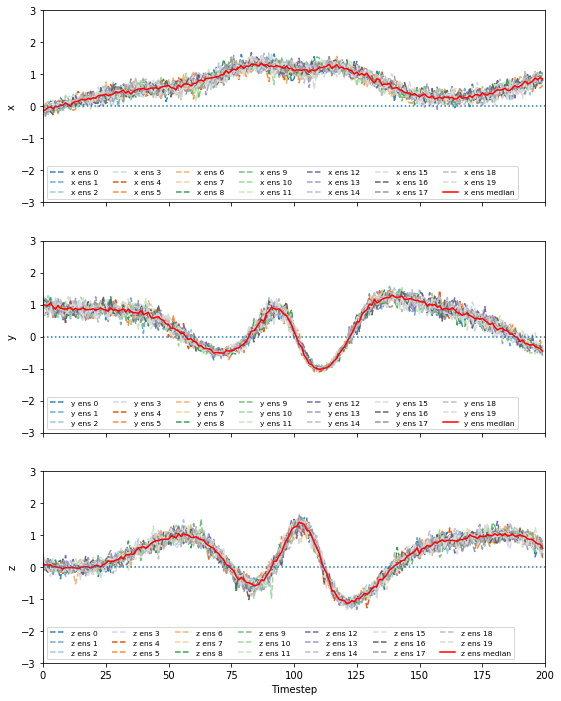

In [11]:
    ###################################################################################
    ########    visualization of lead time dependent prediction - timeseries   ########
    ###################################################################################
    index = np.arange(test_len)
    
    print ('===================  visualize data  =====================')
    print ('===================    time series   =====================')
    #colormap=cm.Pastel2(range(ens))
    #colormap=cm.Accent(range(ens))
    #colormap=cm.Set1(range(ens))
    #colormap=cm.tab10(range(ens))
    colormap=cm.tab20c(range(ens))
    #colormap=cm.jet(range(ens))
    
    # Get colors from colormap
    #colormap = plt.get_cmap('coolwarm', 51)
    #colormap = plt.get_cmap('jet', 51)
    
    fig03 = plt.figure()
    fig03, (ax1,ax2,ax3) = plt.subplots(3, 1, sharex=True)
    fig03.set_size_inches(9, 12, forward=True)
    # each member
    for i in range(ens):
        ax1.plot(index, predictand[i, 0, :, 0] * (x_max - x_min) + x_min,
                 color=colormap[i], linestyle='dashed', label='x ens {}'.format(i))
        ax2.plot(index, predictand[i, 1, :, 0] * (y_max - y_min) + y_min,
                 color=colormap[i], linestyle='dashed', label='y ens {}'.format(i))
        ax3.plot(index, predictand[i, 2, :, 0] * (z_max - z_min) + z_min,
                 color=colormap[i], linestyle='dashed', label='z ens {}'.format(i))
    # median
    ax1.plot(index, predictand_median[0, :, 0] * (x_max - x_min) + x_min,
             color='red', linestyle='solid', label='x ens median')
    ax2.plot(index, predictand_median[1, :, 0] * (y_max - y_min) + y_min,
             color='red', linestyle='solid', label='y ens median')
    ax3.plot(index, predictand_median[2, :, 0] * (z_max - z_min) + z_min,
             color='red', linestyle='solid', label='z ens median')
    
    ax1.axhline(y=0, ls = ':')
    ax2.axhline(y=0, ls = ':')
    ax3.axhline(y=0, ls = ':')
    
    ax1.set_ylim(-3, 3)
    ax2.set_ylim(-3, 3)
    ax3.set_ylim(-3, 3)

    ax1.set_xlim(0, test_len)
    ax2.set_xlim(0, test_len)
    ax3.set_xlim(0, test_len)
    
    ax1.legend(frameon=True, loc=3, prop={'size': 7.5}, ncol=7)
    ax2.legend(frameon=True, loc=3, prop={'size': 7.5}, ncol=7)
    ax3.legend(frameon=True, loc=3, prop={'size': 7.5}, ncol=7)

    ax1.set_ylabel("x")
    ax2.set_ylabel("y")
    ax3.set_ylabel("z")
    
    plt.xlabel("Timestep")

    plt.show()
    fig03.savefig(os.path.join(output_path,
                               'BayesConvLSTM_forecast_lorenz84_series_ens_a{}_b{}_F{}_G{}.png'.format(a, b, F, G)),dpi=200)

===================    trajectory - truncated  =====================


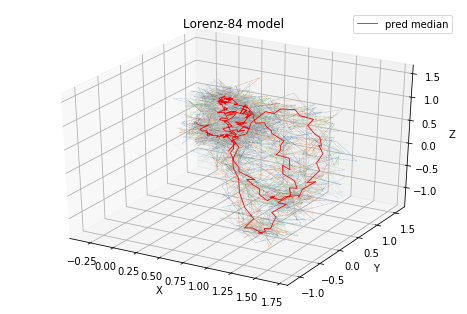

===================    trajectory - full time series  =====================


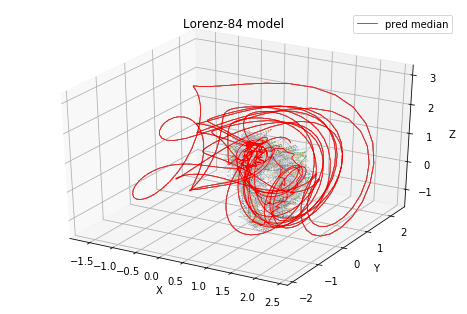

In [12]:
    ###################################################################################
    ########    visualization of lead time dependent prediction - trajectory   ########
    ###################################################################################
    print ('===================    trajectory - truncated  =====================')   
    fig07 = plt.figure(figsize=(8,5.4))
    ax = fig07.gca(projection='3d')
    for i in range(ens):
        ax.plot(predictand[i, 0, :, 0] * (x_max - x_min) + x_min,
                predictand[i, 1, :, 0] * (y_max - y_min) + y_min,
                predictand[i, 2, :, 0] * (z_max - z_min) + z_min,
                color=colormap[i], linestyle='dotted', lw=0.5)
    
    ax.plot(predictand_median[0, :, 0] * (x_max - x_min) + x_min,
            predictand_median[1, :, 0] * (y_max - y_min) + y_min,
            predictand_median[2, :, 0] * (z_max - z_min) + z_min,
            color='red',label='pred median', lw=0.8)
        
    ax.set_xlabel("X")
    ax.set_ylabel("Y")
    ax.set_zlabel("Z")
    ax.set_title("Lorenz-84 model")
    plt.legend()
    plt.show()
    if sense == 'x':
        fig07.savefig(os.path.join(output_path, 'lorenz84_pred_3D_a{}_b{}_F{}_G{}_ens_{}.png'.format(a, b, F, G, ens_num)),dpi=150)
    elif sense == 'a':
        fig07.savefig(os.path.join(output_path, 'lorenz84_pred_3D_x{}_b{}_F{}_G{}_ens_{}.png'.format(x_init, b, F, G, ens_num)),dpi=150)
    elif sense == 'G':
        fig07.savefig(os.path.join(output_path, 'lorenz84_pred_3D_x{}_a{}_b{}_F{}_ens_{}.png'.format(x_init, a, b, F, ens_num)),dpi=150)
    else:
        raise IOError("The chosen variable is not supported for sensitivity experiment!")
    
    print ('===================    trajectory - full time series  =====================')   
    predictand_full = np.zeros((ens, 3, num_steps), dtype=float) # create full time series for the predictand
    # create full time series for the predictand
    x_2D = np.repeat(x[np.newaxis,:], ens, 0)
    y_2D = np.repeat(y[np.newaxis,:], ens, 0)
    z_2D = np.repeat(z[np.newaxis,:], ens, 0)
    
    predictand_full[:,0,:-test_len] = x_2D[:,:-test_len]
    predictand_full[:,1,:-test_len] = y_2D[:,:-test_len]
    predictand_full[:,2,:-test_len] = z_2D[:,:-test_len]
    
    predictand_full[:,0,-test_len:] = predictand[:,0,:,0] * (x_max - x_min) + x_min
    predictand_full[:,1,-test_len:] = predictand[:,1,:,0] * (y_max - y_min) + y_min
    predictand_full[:,2,-test_len:] = predictand[:,2,:,0] * (z_max - z_min) + z_min
    
    predictand_full_median = np.median(predictand_full, 0)

    fig08 = plt.figure(figsize=(8,5.4))
    ax = fig08.gca(projection='3d')
    for i in range(ens):
        ax.plot(predictand_full[i, 0, :],
                predictand_full[i, 1, :],
                predictand_full[i, 2, :], color=colormap[i], linestyle='dashed', lw=0.5)
    
    ax.plot(predictand_full_median[0, :],
            predictand_full_median[1, :],
            predictand_full_median[2, :],
            color='red', label='pred median', lw=0.8)
        
    ax.set_xlabel("X")
    ax.set_ylabel("Y")
    ax.set_zlabel("Z")
    ax.set_title("Lorenz-84 model")
    plt.legend()
    plt.show()
    if sense == 'x':
        fig08.savefig(os.path.join(output_path, 'lorenz84_pred_3D_full_a{}_b{}_F{}_G{}_ens_{}.png'.format(a, b, F, G, ens_num)),dpi=150)
    elif sense == 'a':
        fig08.savefig(os.path.join(output_path, 'lorenz84_pred_3D_full_x{}_b{}_F{}_G{}_ens_{}.png'.format(x_init, b, F, G, ens_num)),dpi=150)
    elif sense == 'G':
        fig08.savefig(os.path.join(output_path, 'lorenz84_pred_3D_full_x{}_a{}_b{}_F{}_ens_{}.png'.format(x_init, a, b, F, ens_num)),dpi=150)
    else:
        raise IOError("The chosen variable is not supported for sensitivity experiment!")

===================  load data  =====================
===================  visualize data  =====================


<Figure size 432x288 with 0 Axes>

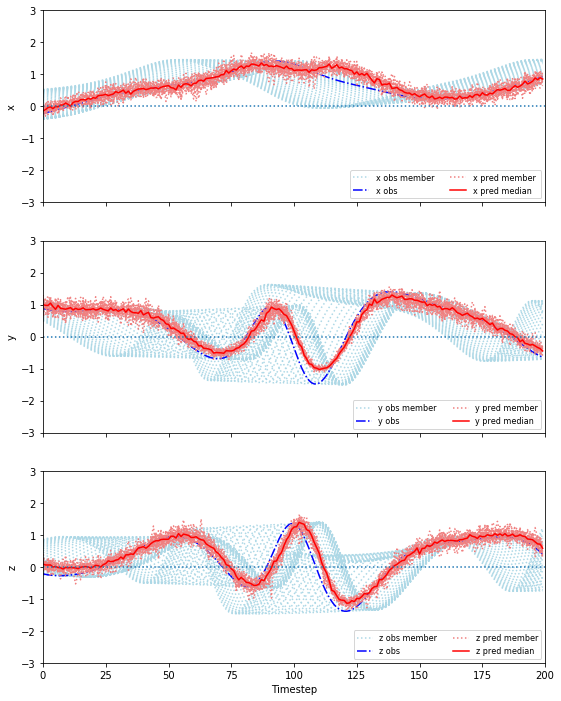

In [13]:
    #############################################################################################################
    ###########        Comparison Lorenz 84 model ensemble output and BayesConvLSTM forecast          ###########
    #############################################################################################################
    print ('===================  load data  =====================')
    # save Lorens model output
    index = np.arange(test_len)
    # number of ensembles
    ens = 20
    ens_obs = 51
    data_ens = np.zeros((ens_obs, 3, test_len), dtype=float)
    # load data
    for i in range(ens_obs):
        if sense == 'x':
            if model_type == 'lorenz84':
                dataset = Dataset(os.path.join(data_path, 'lorenz84_series_a{}_b{}_F{}_G{}_ens_{}.nc'.format(a, b, F, G, i)))
            elif model_type == 'lorenz84ex':
                dataset = Dataset(os.path.join(data_path, 'lorenz84_ex_series_a{}_b{}_F{}_G{}_ens_{}.nc'.format(a, b, F, G, i)))
        elif sense == 'a':
            if model_type == 'lorenz84':
                dataset = Dataset(os.path.join(data_path, 'lorenz84_series_x{}_b{}_F{}_G{}_ens_{}.nc'.format(x_init, b, F, G, i)))
            elif model_type == 'lorenz84ex':
                dataset = Dataset(os.path.join(data_path, 'lorenz84_ex_series_x{}_b{}_F{}_G{}_ens_{}.nc'.format(x_init, b, F, G, i)))
        elif sense == 'G':
            if model_type == 'lorenz84':
                dataset = Dataset(os.path.join(data_path, 'lorenz84_series_x{}_a{}_b{}_F{}_ens_{}.nc'.format(x_init, a, b, F, i)))
            elif model_type == 'lorenz84ex':
                dataset = Dataset(os.path.join(data_path, 'lorenz84_ex_series_x{}_a{}_b{}_F{}_ens_{}.nc'.format(x_init, a, b, F, i)))
        else:
            raise IOError("The chosen variable is not supported for sensitivity experiment!")    
        data_ens[i,:,:] = dataset.variables['series'][:, -test_len:]

    print ('===================  visualize data  =====================')
    ##################################################################
    ###########        Time series of testing data         ###########
    ##################################################################
    fig04 = plt.figure()
    fig04, (ax1,ax2,ax3) = plt.subplots(3, 1, sharex=True)
    fig04.set_size_inches(9, 12, forward=True)
    
    # Lorenz 84 model time series
    for i in range(ens_obs):
        if i == 0: # for the legend
            ax1.plot(index, data_ens[i, 0, :], color='lightblue', linestyle='dotted', label='x obs member')
            ax2.plot(index, data_ens[i, 1, :], color='lightblue', linestyle='dotted',label='y obs member')
            ax3.plot(index, data_ens[i, 2, :], color='lightblue', linestyle='dotted',label='z obs member')
        else:
            ax1.plot(index, data_ens[i, 0, :], color='lightblue', linestyle='dotted')
            ax2.plot(index, data_ens[i, 1, :], color='lightblue', linestyle='dotted')
            ax3.plot(index, data_ens[i, 2, :], color='lightblue', linestyle='dotted')
    
    # without perturbation
    #ax1.plot(index, np.median(data_ens[:, 0, :], 0), color='blue', linestyle='dashdot', label='x obs')
    ax1.plot(index, data_ens[24, 0, :], color='blue', linestyle='dashdot', label='x obs')
    #ax2.plot(index, np.median(data_ens[:, 1, :], 0), color='blue', linestyle='dashdot', label='y obs').
    ax2.plot(index, data_ens[24, 1, :], color='blue', linestyle='dashdot', label='y obs')
    #ax3.plot(index, np.median(data_ens[:, 2, :], 0), color='blue', linestyle='dashdot', label='z obs')
    ax3.plot(index, data_ens[24, 2, :], color='blue', linestyle='dashdot', label='z obs')

    # forecast time series
    for i in range(ens):
        if i == 0: # for the legend
            ax1.plot(index, predictand[i, 0, :, 0] * (x_max - x_min) + x_min,
                     color='lightcoral', linestyle='dotted', label='x pred member ')
            ax2.plot(index, predictand[i, 1, :, 0] * (y_max - y_min) + y_min,
                     color='lightcoral', linestyle='dotted', label='y pred member')
            ax3.plot(index, predictand[i, 2, :, 0] * (z_max - z_min) + z_min,
                     color='lightcoral', linestyle='dotted', label='z pred member')    
        else: 
            ax1.plot(index, predictand[i, 0, :, 0] * (x_max - x_min) + x_min,
                     color='lightcoral', linestyle='dotted')
            ax2.plot(index, predictand[i, 1, :, 0] * (y_max - y_min) + y_min,
                     color='lightcoral', linestyle='dotted')
            ax3.plot(index, predictand[i, 2, :, 0] * (z_max - z_min) + z_min,
                     color='lightcoral', linestyle='dotted')        

    # median forecast time series
    ax1.plot(index, predictand_median[0, :, 0] * (x_max - x_min) + x_min,
             color='red', linestyle='solid', label='x pred median')
    ax2.plot(index, predictand_median[1, :, 0] * (y_max - y_min) + y_min,
             color='red', linestyle='solid', label='y pred median')
    ax3.plot(index, predictand_median[2, :, 0] * (z_max - z_min) + z_min,
             color='red', linestyle='solid', label='z pred median')        
        
    ax1.axhline(y=0, ls = ':')
    ax2.axhline(y=0, ls = ':')
    ax3.axhline(y=0, ls = ':')
    
    ax1.set_ylim(-3, 3)
    ax2.set_ylim(-3, 3)
    ax3.set_ylim(-3, 3)

    ax1.set_xlim(0, test_len)
    ax2.set_xlim(0, test_len)
    ax3.set_xlim(0, test_len)
    
    ax1.legend(frameon=True, loc=4, prop={'size': 8}, ncol=2)
    ax2.legend(frameon=True, loc=4, prop={'size': 8}, ncol=2)
    ax3.legend(frameon=True, loc=4, prop={'size': 8}, ncol=2)
    
    ax1.set_ylabel("x")
    ax2.set_ylabel("y")
    ax3.set_ylabel("z")
    
    plt.xlabel("Timestep")

    plt.show()
    if sense == 'x':
        fig04.savefig(os.path.join(output_path,'BayesConvLSTM_forecast_lorenz84_series_comp_ens_a{}_b{}_F{}_G{}.png'.format(a, b, F, G)),dpi=200)
    elif sense == 'a':
        fig04.savefig(os.path.join(output_path,'BayesConvLSTM_forecast_lorenz84_series_comp_ens_x{}_b{}_F{}_G{}.png'.format(x_init, b, F, G)),dpi=200)
    elif sense == 'G':
        fig04.savefig(os.path.join(output_path,'BayesConvLSTM_forecast_lorenz84_series_comp_ens_x{}_a{}_b{}_F{}.png'.format(x_init, a, b, F)),dpi=200)
    else:
        raise IOError("The chosen variable is not supported for sensitivity experiment!")      

===================    trajectory - truncated  =====================


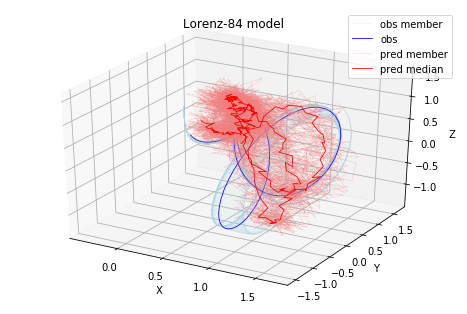

===================    trajectory - full time series  =====================


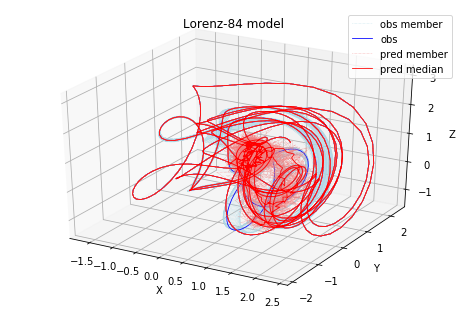

In [14]:
    ###################################################################################
    ########    visualization of lead time dependent prediction - trajectory   ########
    ###################################################################################
    # number of ensembles
    ens = 20
    ens_obs = 51
    data_ens = np.zeros((ens_obs, 3, test_len), dtype=float)
    # load data
    for i in range(ens_obs):
        if sense == 'x':
            if model_type == 'lorenz84':
                dataset = Dataset(os.path.join(data_path, 'lorenz84_series_a{}_b{}_F{}_G{}_ens_{}.nc'.format(a, b, F, G, i)))
            elif model_type == 'lorenz84ex':
                dataset = Dataset(os.path.join(data_path, 'lorenz84_ex_series_a{}_b{}_F{}_G{}_ens_{}.nc'.format(a, b, F, G, i)))
        elif sense == 'a':
            if model_type == 'lorenz84':
                dataset = Dataset(os.path.join(data_path, 'lorenz84_series_x{}_b{}_F{}_G{}_ens_{}.nc'.format(x_init, b, F, G, i)))
            elif model_type == 'lorenz84ex':
                dataset = Dataset(os.path.join(data_path, 'lorenz84_ex_series_x{}_b{}_F{}_G{}_ens_{}.nc'.format(x_init, b, F, G, i)))
        elif sense == 'G':
            if model_type == 'lorenz84':
                dataset = Dataset(os.path.join(data_path, 'lorenz84_series_x{}_a{}_b{}_F{}_ens_{}.nc'.format(x_init, a, b, F, i)))
            elif model_type == 'lorenz84ex':
                dataset = Dataset(os.path.join(data_path, 'lorenz84_ex_series_x{}_a{}_b{}_F{}_ens_{}.nc'.format(x_init, a, b, F, i)))
        else:
            raise IOError("The chosen variable is not supported for sensitivity experiment!")    
        data_ens[i,:,:] = dataset.variables['series'][:, -test_len:]
    
    print ('===================    trajectory - truncated  =====================')   
    fig09 = plt.figure(figsize=(8,5.4))
    ax = fig09.gca(projection='3d')

    for i in range(ens_obs):
        if i == 0:
            ax.plot(data_ens[i, 0, :], data_ens[i, 1, :], data_ens[i, 2, :],
                    color='lightblue', linestyle='dotted', label='obs member', lw=0.5)
        else:
            ax.plot(data_ens[i, 0, :], data_ens[i, 1, :], data_ens[i, 2, :],
                    color='lightblue', linestyle='dotted', lw=0.5)
    
    ax.plot(data_ens[24, 0, :], data_ens[24, 1, :], data_ens[24, 2, :],
            color='blue', label='obs', lw=0.8)
    
    for i in range(ens):
        if i == 0:
            ax.plot(predictand[i, 0, :, 0] * (x_max - x_min) + x_min,
                    predictand[i, 1, :, 0] * (y_max - y_min) + y_min,
                    predictand[i, 2, :, 0] * (z_max - z_min) + z_min,
                    color='lightcoral', linestyle='dotted', label='pred member', lw=0.5)
        else:
            ax.plot(predictand[i, 0, :, 0] * (x_max - x_min) + x_min,
                    predictand[i, 1, :, 0] * (y_max - y_min) + y_min,
                    predictand[i, 2, :, 0] * (z_max - z_min) + z_min,
                    color='lightcoral', linestyle='dotted', lw=0.5)            
    
    ax.plot(predictand_median[0, :, 0] * (x_max - x_min) + x_min,
            predictand_median[1, :, 0] * (y_max - y_min) + y_min,
            predictand_median[2, :, 0] * (z_max - z_min) + z_min,
            color='red', label='pred median', lw=0.8)
        
    ax.set_xlabel("X")
    ax.set_ylabel("Y")
    ax.set_zlabel("Z")
    ax.set_title("Lorenz-84 model")
    plt.legend()
    plt.show()
    if sense == 'x':
        fig09.savefig(os.path.join(output_path, 'lorenz84_pred_obs_3D_a{}_b{}_F{}_G{}_ens_{}.png'.format(a, b, F, G, ens_num)),dpi=150)
    elif sense == 'a':
        fig09.savefig(os.path.join(output_path, 'lorenz84_pred_obs_3D_x{}_b{}_F{}_G{}_ens_{}.png'.format(x_init, b, F, G, ens_num)),dpi=150)
    elif sense == 'G':
        fig09.savefig(os.path.join(output_path, 'lorenz84_pred_obs_3D_x{}_a{}_b{}_F{}_ens_{}.png'.format(x_init, a, b, F, ens_num)),dpi=150)
    else:
        raise IOError("The chosen variable is not supported for sensitivity experiment!")
    
    print ('===================    trajectory - full time series  =====================')   
    ens = 20
    ens_obs = 51
    data_ens = np.zeros((ens_obs, 3, num_steps), dtype=float)
    predictand_full = np.zeros((ens, 3, num_steps), dtype=float) # create full time series for the predictand
    # load data
    for i in range(ens_obs):
        if sense == 'x':
            if model_type == 'lorenz84':
                dataset = Dataset(os.path.join(data_path, 'lorenz84_series_a{}_b{}_F{}_G{}_ens_{}.nc'.format(a, b, F, G, i)))
            elif model_type == 'lorenz84ex':
                dataset = Dataset(os.path.join(data_path, 'lorenz84_ex_series_a{}_b{}_F{}_G{}_ens_{}.nc'.format(a, b, F, G, i)))
        elif sense == 'a':
            if model_type == 'lorenz84':
                dataset = Dataset(os.path.join(data_path, 'lorenz84_series_x{}_b{}_F{}_G{}_ens_{}.nc'.format(x_init, b, F, G, i)))
            elif model_type == 'lorenz84ex':
                dataset = Dataset(os.path.join(data_path, 'lorenz84_ex_series_x{}_b{}_F{}_G{}_ens_{}.nc'.format(x_init, b, F, G, i)))
        elif sense == 'G':
            if model_type == 'lorenz84':
                dataset = Dataset(os.path.join(data_path, 'lorenz84_series_x{}_a{}_b{}_F{}_ens_{}.nc'.format(x_init, a, b, F, i)))
            elif model_type == 'lorenz84ex':
                dataset = Dataset(os.path.join(data_path, 'lorenz84_ex_series_x{}_a{}_b{}_F{}_ens_{}.nc'.format(x_init, a, b, F, i)))
        else:
            raise IOError("The chosen variable is not supported for sensitivity experiment!")    
        data_ens[i,:,:] = dataset.variables['series'][:]
    # create full time series for the predictand
    x_2D = np.repeat(x[np.newaxis,:], ens, 0)
    y_2D = np.repeat(y[np.newaxis,:], ens, 0)
    z_2D = np.repeat(z[np.newaxis,:], ens, 0)
    
    predictand_full[:,0,:-test_len] = x_2D[:,:-test_len]
    predictand_full[:,1,:-test_len] = y_2D[:,:-test_len]
    predictand_full[:,2,:-test_len] = z_2D[:,:-test_len]
    
    predictand_full[:,0,-test_len:] = predictand[:,0,:,0] * (x_max - x_min) + x_min
    predictand_full[:,1,-test_len:] = predictand[:,1,:,0] * (y_max - y_min) + y_min
    predictand_full[:,2,-test_len:] = predictand[:,2,:,0] * (z_max - z_min) + z_min
    
    predictand_full_median = np.median(predictand_full, 0)

    fig10 = plt.figure(figsize=(8,5.4))
    ax = fig10.gca(projection='3d')

    for i in range(ens_obs):
        if i == 0:
            ax.plot(data_ens[i, 0, :], data_ens[i, 1, :], data_ens[i, 2, :],
                    color='lightblue', linestyle='dotted', label='obs member', lw=0.5)
        else:
            ax.plot(data_ens[i, 0, :], data_ens[i, 1, :], data_ens[i, 2, :],
                    color='lightblue', linestyle='dotted', lw=0.5)            

    
    ax.plot(data_ens[24, 0, :], data_ens[24, 1, :], data_ens[24, 2, :],
            color='blue', label='obs', lw=0.8)
    
    for i in range(ens):
        if i == 0:
            ax.plot(predictand_full[i, 0, :],
                    predictand_full[i, 1, :],
                    predictand_full[i, 2, :],
                    color='lightcoral', linestyle='dotted', label='pred member', lw=0.5)
        else:
            ax.plot(predictand_full[i, 0, :],
                    predictand_full[i, 1, :],
                    predictand_full[i, 2, :],
                    color='lightcoral', linestyle='dotted', lw=0.5)
    
    ax.plot(predictand_full_median[0, :],
            predictand_full_median[1, :],
            predictand_full_median[2, :],
            color='red', label='pred median', lw=0.8)
    
    ax.set_xlabel("X")
    ax.set_ylabel("Y")
    ax.set_zlabel("Z")
    ax.set_title("Lorenz-84 model")
    plt.legend()
    plt.show()
    if sense == 'x':
        fig10.savefig(os.path.join(output_path, 'lorenz84_pred_obs_3D_full_a{}_b{}_F{}_G{}_ens_{}.png'.format(a, b, F, G, ens_num)),dpi=150)
    elif sense == 'a':
        fig10.savefig(os.path.join(output_path, 'lorenz84_pred_obs_3D_full_x{}_b{}_F{}_G{}_ens_{}.png'.format(x_init, b, F, G, ens_num)),dpi=150)
    elif sense == 'G':
        fig10.savefig(os.path.join(output_path, 'lorenz84_pred_obs_3D_full_x{}_a{}_b{}_F{}_ens_{}.png'.format(x_init, a, b, F, ens_num)),dpi=150)
    else:
        raise IOError("The chosen variable is not supported for sensitivity experiment!")

In [13]:
    ###############################################################################
    #######       Compute power spectrum of testing data - full series      #######
    ###############################################################################
    # number of ensembles
    ens = 20
    ens_obs = 51
    data_ens = np.zeros((ens_obs, 3, num_steps), dtype=float)
    predictand_full = np.zeros((ens, 3, num_steps), dtype=float) # create full time series for the predictand
    # load data
    for i in range(ens_obs):
        if sense == 'x':
            if model_type == 'lorenz84':
                dataset = Dataset(os.path.join(data_path, 'lorenz84_series_a{}_b{}_F{}_G{}_ens_{}.nc'.format(a, b, F, G, i)))
            elif model_type == 'lorenz84ex':
                dataset = Dataset(os.path.join(data_path, 'lorenz84_ex_series_a{}_b{}_F{}_G{}_ens_{}.nc'.format(a, b, F, G, i)))
        elif sense == 'a':
            if model_type == 'lorenz84':
                dataset = Dataset(os.path.join(data_path, 'lorenz84_series_x{}_b{}_F{}_G{}_ens_{}.nc'.format(x_init, b, F, G, i)))
            elif model_type == 'lorenz84ex':
                dataset = Dataset(os.path.join(data_path, 'lorenz84_ex_series_x{}_b{}_F{}_G{}_ens_{}.nc'.format(x_init, b, F, G, i)))
        elif sense == 'G':
            if model_type == 'lorenz84':
                dataset = Dataset(os.path.join(data_path, 'lorenz84_series_x{}_a{}_b{}_F{}_ens_{}.nc'.format(x_init, a, b, F, i)))
            elif model_type == 'lorenz84ex':
                dataset = Dataset(os.path.join(data_path, 'lorenz84_ex_series_x{}_a{}_b{}_F{}_ens_{}.nc'.format(x_init, a, b, F, i)))
        else:
            raise IOError("The chosen variable is not supported for sensitivity experiment!")    
        data_ens[i,:,:] = dataset.variables['series'][:]
    # create full time series for the predictand
    x_2D = np.repeat(x[np.newaxis,:], ens, 0)
    y_2D = np.repeat(y[np.newaxis,:], ens, 0)
    z_2D = np.repeat(z[np.newaxis,:], ens, 0)
    
    predictand_full[:,0,:-test_len] = x_2D[:,:-test_len]
    predictand_full[:,1,:-test_len] = y_2D[:,:-test_len]
    predictand_full[:,2,:-test_len] = z_2D[:,:-test_len]
    
    predictand_full[:,0,-test_len:] = predictand[:,0,:,0] * (x_max - x_min) + x_min
    predictand_full[:,1,-test_len:] = predictand[:,1,:,0] * (y_max - y_min) + y_min
    predictand_full[:,2,-test_len:] = predictand[:,2,:,0] * (z_max - z_min) + z_min
    
    # FFT
    ps_obs_ens = np.zeros(data_ens.shape, dtype=float)
    ps_pred_ens = np.zeros(predictand_full.shape, dtype=float)
    
    # calculate the frequency
    freqs = np.fft.fftfreq(num_steps, dt)
    # sort the index by frequency
    idx = np.argsort(freqs)
    # re-arrange frequency after sorting
    freqs_re = freqs[idx]
    
    # FFT of Lorenz 84 model
    for i in range(ens_obs):
        ps_x_obs = np.abs(np.fft.fft(data_ens[i, 0, :])) ** 2
        ps_y_obs = np.abs(np.fft.fft(data_ens[i, 1, :])) ** 2
        ps_z_obs = np.abs(np.fft.fft(data_ens[i, 2, :])) ** 2
        
        # save fft results and sort them by frequency
        ps_obs_ens[i, 0, :] = ps_x_obs[idx]
        ps_obs_ens[i, 1, :] = ps_y_obs[idx]
        ps_obs_ens[i, 2, :] = ps_z_obs[idx]
    
    # FFT of forecast
    for i in range(ens):        
        ps_x_pred = np.abs(np.fft.fft(predictand_full[i, 0, :])) ** 2
        ps_y_pred = np.abs(np.fft.fft(predictand_full[i, 1, :])) ** 2
        ps_z_pred = np.abs(np.fft.fft(predictand_full[i, 2, :])) ** 2
        
        # save fft results and sort them by frequency    
        ps_pred_ens[i, 0, :] = ps_x_pred[idx]
        ps_pred_ens[i, 1, :] = ps_y_pred[idx]
        ps_pred_ens[i, 2, :] = ps_z_pred[idx]

<Figure size 432x288 with 0 Axes>

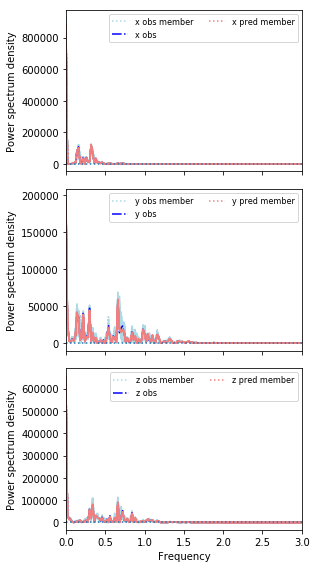

In [14]:
    ###################################################################################
    ###########       Power spectrum of testing data - full timeseries      ###########
    ###################################################################################  
    fig05 = plt.figure()
    fig05, (ax1,ax2,ax3) = plt.subplots(3, 1, sharex=True)
    fig05.set_size_inches(4.5, 8, forward=True)
    
    # Lorenz 84 model time series
    for i in range(ens_obs):
        if i == 0: # for the legend
            ax1.plot(freqs_re[num_steps//2:], ps_obs_ens[i, 0, num_steps//2:], color='lightblue', linestyle='dotted', label='x obs member')
            ax2.plot(freqs_re[num_steps//2:], ps_obs_ens[i, 1, num_steps//2:], color='lightblue', linestyle='dotted',label='y obs member')
            ax3.plot(freqs_re[num_steps//2:], ps_obs_ens[i, 2, num_steps//2:], color='lightblue', linestyle='dotted',label='z obs member')
        else:
            ax1.plot(freqs_re[num_steps//2:], ps_obs_ens[i, 0, num_steps//2:], color='lightblue', linestyle='dotted')
            ax2.plot(freqs_re[num_steps//2:], ps_obs_ens[i, 1, num_steps//2:], color='lightblue', linestyle='dotted')
            ax3.plot(freqs_re[num_steps//2:], ps_obs_ens[i, 2, num_steps//2:], color='lightblue', linestyle='dotted')
    
    # without perturbation
    #ax1.plot(freqs_re[test_len//2:], np.median(ps_obs_ens[:, 0, :], 0), color='blue', linestyle='dashdot', label='x obs')
    ax1.plot(freqs_re[num_steps//2:], ps_obs_ens[24, 0, num_steps//2:], color='blue', linestyle='dashdot', label='x obs')
    #ax2.plot(freqs_re[test_len//2:], np.median(ps_obs_ens[:, 1, :], 0), color='blue', linestyle='dashdot', label='y obs').
    ax2.plot(freqs_re[num_steps//2:], ps_obs_ens[24, 1, num_steps//2:], color='blue', linestyle='dashdot', label='y obs')
    #ax3.plot(freqs_re[test_len//2:], np.median(ps_obs_ens[:, 2, :], 0), color='blue', linestyle='dashdot', label='z obs')
    ax3.plot(freqs_re[num_steps//2:], ps_obs_ens[24, 2, num_steps//2:], color='blue', linestyle='dashdot', label='z obs')

    # forecast time series
    for i in range(ens):
        if i == 0: # for the legend
            ax1.plot(freqs_re[num_steps//2:], ps_pred_ens[i, 0, num_steps//2:], color='lightcoral', linestyle='dotted', label='x pred member')
            ax2.plot(freqs_re[num_steps//2:], ps_pred_ens[i, 1, num_steps//2:], color='lightcoral', linestyle='dotted', label='y pred member')
            ax3.plot(freqs_re[num_steps//2:], ps_pred_ens[i, 2, num_steps//2:], color='lightcoral', linestyle='dotted', label='z pred member')    
        else: 
            ax1.plot(freqs_re[num_steps//2:], ps_pred_ens[i, 0, num_steps//2:], color='lightcoral', linestyle='dotted')
            ax2.plot(freqs_re[num_steps//2:], ps_pred_ens[i, 1, num_steps//2:], color='lightcoral', linestyle='dotted')
            ax3.plot(freqs_re[num_steps//2:], ps_pred_ens[i, 2, num_steps//2:], color='lightcoral', linestyle='dotted')        

    # median forecast time series
    #ax1.plot(index, predictand_median[0, :, 0] * (x_max - x_min) + x_min,
    #         color='red', linestyle='solid', label='x pred median')
    #ax2.plot(index, predictand_median[1, :, 0] * (y_max - y_min) + y_min,
    #         color='red', linestyle='solid', label='y pred median')
    #ax3.plot(index, predictand_median[2, :, 0] * (z_max - z_min) + z_min,
    #         color='red', linestyle='solid', label='z pred median')        
        
    ax1.axhline(y=0, ls = ':')
    ax2.axhline(y=0, ls = ':')
    ax3.axhline(y=0, ls = ':')
    
    #ax1.set_ylim(-3, 3)
    #ax2.set_ylim(-3, 3)
    #ax3.set_ylim(-3, 3)

    ax1.set_xlim(0, 3)
    ax2.set_xlim(0, 3)
    ax3.set_xlim(0, 3)
    
    ax1.legend(frameon=True, loc=0, prop={'size': 8}, ncol=2)
    ax2.legend(frameon=True, loc=0, prop={'size': 8}, ncol=2)
    ax3.legend(frameon=True, loc=0, prop={'size': 8}, ncol=2)
    
    ax1.set_ylabel("Power spectrum density")
    ax2.set_ylabel("Power spectrum density")
    ax3.set_ylabel("Power spectrum density")
    
    plt.xlabel("Frequency")
    
    plt.tight_layout()

    plt.show()
    if sense == 'x':
        fig05.savefig(os.path.join(output_path,'BayesConvLSTM_forecast_lorenz84_power_spectrum_full_ens_a{}_b{}_F{}_G{}.png'.format(a, b, F, G)),dpi=200)
    elif sense == 'a':
        fig05.savefig(os.path.join(output_path,'BayesConvLSTM_forecast_lorenz84_power_spectrum_full_ens_x{}_b{}_F{}_G{}.png'.format(x_init, b, F, G)),dpi=200)
    elif sense == 'G':
        fig05.savefig(os.path.join(output_path,'BayesConvLSTM_forecast_lorenz84_power_spectrum_full_ens_x{}_a{}_b{}_F{}.png'.format(x_init, a, b, F)),dpi=200)
    else:
        raise IOError("The chosen variable is not supported for sensitivity experiment!")      

In [ ]:
    #############################################################################
    #######       Compute power spectrum of testing data - tuncation      #######
    #############################################################################
    # number of ensembles
    ens = 20
    ens_obs = 51
    data_ens = np.zeros((ens_obs, 3, test_len), dtype=float)
    # load data
    for i in range(ens_obs):
        if sense == 'x':
            if model_type == 'lorenz84':
                dataset = Dataset(os.path.join(data_path, 'lorenz84_series_a{}_b{}_F{}_G{}_ens_{}.nc'.format(a, b, F, G, i)))
            elif model_type == 'lorenz84ex':
                dataset = Dataset(os.path.join(data_path, 'lorenz84_ex_series_a{}_b{}_F{}_G{}_ens_{}.nc'.format(a, b, F, G, i)))
        elif sense == 'a':
            if model_type == 'lorenz84':
                dataset = Dataset(os.path.join(data_path, 'lorenz84_series_x{}_b{}_F{}_G{}_ens_{}.nc'.format(x_init, b, F, G, i)))
            elif model_type == 'lorenz84ex':
                dataset = Dataset(os.path.join(data_path, 'lorenz84_ex_series_x{}_b{}_F{}_G{}_ens_{}.nc'.format(x_init, b, F, G, i)))
        elif sense == 'G':
            if model_type == 'lorenz84':
                dataset = Dataset(os.path.join(data_path, 'lorenz84_series_x{}_a{}_b{}_F{}_ens_{}.nc'.format(x_init, a, b, F, i)))
            elif model_type == 'lorenz84ex':
                dataset = Dataset(os.path.join(data_path, 'lorenz84_ex_series_x{}_a{}_b{}_F{}_ens_{}.nc'.format(x_init, a, b, F, i)))
        else:
            raise IOError("The chosen variable is not supported for sensitivity experiment!")    
        data_ens[i,:,:] = dataset.variables['series'][:, -test_len:]
    # FFT
    ps_obs_ens = np.zeros(data_ens.shape, dtype=float)
    ps_pred_ens = np.zeros((ens, 3, test_len), dtype=float)
    
    # calculate the frequency
    freqs = np.fft.fftfreq(test_len, dt)
    # sort the index by frequency
    idx = np.argsort(freqs)
    # re-arrange frequency after sorting
    freqs_re = freqs[idx]
    
    # FFT of Lorenz 84 model
    for i in range(ens_obs):
        ps_x_obs = np.abs(np.fft.fft(data_ens[i, 0, :])) ** 2
        ps_y_obs = np.abs(np.fft.fft(data_ens[i, 1, :])) ** 2
        ps_z_obs = np.abs(np.fft.fft(data_ens[i, 2, :])) ** 2
        
        # save fft results and sort them by frequency
        ps_obs_ens[i, 0, :] = ps_x_obs[idx]
        ps_obs_ens[i, 1, :] = ps_y_obs[idx]
        ps_obs_ens[i, 2, :] = ps_z_obs[idx]
    
    # FFT of forecast
    for i in range(ens):        
        ps_x_pred = np.abs(np.fft.fft(predictand[i, 0, :, 0] * (x_max - x_min) + x_min)) ** 2
        ps_y_pred = np.abs(np.fft.fft(predictand[i, 1, :, 0] * (y_max - y_min) + y_min)) ** 2
        ps_z_pred = np.abs(np.fft.fft(predictand[i, 2, :, 0] * (z_max - z_min) + z_min)) ** 2
        
        # save fft results and sort them by frequency    
        ps_pred_ens[i, 0, :] = ps_x_pred[idx]
        ps_pred_ens[i, 1, :] = ps_y_pred[idx]
        ps_pred_ens[i, 2, :] = ps_z_pred[idx]

<Figure size 432x288 with 0 Axes>

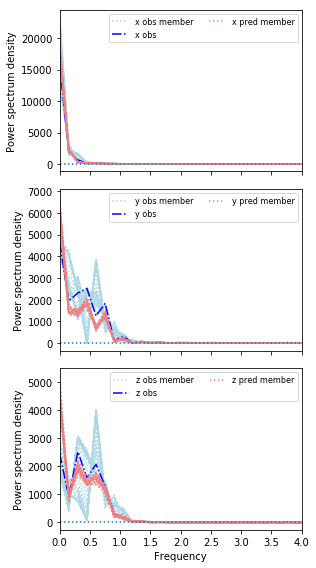

In [14]:
    #############################################################################
    ###########       Power spectrum of testing data- tuncation       ###########
    #############################################################################
    fig06 = plt.figure()
    fig06, (ax1,ax2,ax3) = plt.subplots(3, 1, sharex=True)
    fig06.set_size_inches(4.5, 8, forward=True)
    
    # Lorenz 84 model time series
    for i in range(ens_obs):
        if i == 0: # for the legend
            ax1.plot(freqs_re[test_len//2:], ps_obs_ens[i, 0, test_len//2:], color='lightblue', linestyle='dotted', label='x obs member')
            ax2.plot(freqs_re[test_len//2:], ps_obs_ens[i, 1, test_len//2:], color='lightblue', linestyle='dotted',label='y obs member')
            ax3.plot(freqs_re[test_len//2:], ps_obs_ens[i, 2, test_len//2:], color='lightblue', linestyle='dotted',label='z obs member')
        else:
            ax1.plot(freqs_re[test_len//2:], ps_obs_ens[i, 0, test_len//2:], color='lightblue', linestyle='dotted')
            ax2.plot(freqs_re[test_len//2:], ps_obs_ens[i, 1, test_len//2:], color='lightblue', linestyle='dotted')
            ax3.plot(freqs_re[test_len//2:], ps_obs_ens[i, 2, test_len//2:], color='lightblue', linestyle='dotted')
    
    # without perturbation
    #ax1.plot(freqs_re[test_len//2:], np.median(ps_obs_ens[:, 0, :], 0), color='blue', linestyle='dashdot', label='x obs')
    ax1.plot(freqs_re[test_len//2:], ps_obs_ens[24, 0, test_len//2:], color='blue', linestyle='dashdot', label='x obs')
    #ax2.plot(freqs_re[test_len//2:], np.median(ps_obs_ens[:, 1, :], 0), color='blue', linestyle='dashdot', label='y obs').
    ax2.plot(freqs_re[test_len//2:], ps_obs_ens[24, 1, test_len//2:], color='blue', linestyle='dashdot', label='y obs')
    #ax3.plot(freqs_re[test_len//2:], np.median(ps_obs_ens[:, 2, :], 0), color='blue', linestyle='dashdot', label='z obs')
    ax3.plot(freqs_re[test_len//2:], ps_obs_ens[24, 2, test_len//2:], color='blue', linestyle='dashdot', label='z obs')

    # forecast time series
    for i in range(ens):
        if i == 0: # for the legend
            ax1.plot(freqs_re[test_len//2:], ps_pred_ens[i, 0, test_len//2:], color='lightcoral', linestyle='dotted', label='x pred member')
            ax2.plot(freqs_re[test_len//2:], ps_pred_ens[i, 1, test_len//2:], color='lightcoral', linestyle='dotted', label='y pred member')
            ax3.plot(freqs_re[test_len//2:], ps_pred_ens[i, 2, test_len//2:], color='lightcoral', linestyle='dotted', label='z pred member')    
        else: 
            ax1.plot(freqs_re[test_len//2:], ps_pred_ens[i, 0, test_len//2:], color='lightcoral', linestyle='dotted')
            ax2.plot(freqs_re[test_len//2:], ps_pred_ens[i, 1, test_len//2:], color='lightcoral', linestyle='dotted')
            ax3.plot(freqs_re[test_len//2:], ps_pred_ens[i, 2, test_len//2:], color='lightcoral', linestyle='dotted')        

    # median forecast time series
    #ax1.plot(index, predictand_median[0, :, 0] * (x_max - x_min) + x_min,
    #         color='red', linestyle='solid', label='x pred median')
    #ax2.plot(index, predictand_median[1, :, 0] * (y_max - y_min) + y_min,
    #         color='red', linestyle='solid', label='y pred median')
    #ax3.plot(index, predictand_median[2, :, 0] * (z_max - z_min) + z_min,
    #         color='red', linestyle='solid', label='z pred median')        
        
    ax1.axhline(y=0, ls = ':')
    ax2.axhline(y=0, ls = ':')
    ax3.axhline(y=0, ls = ':')
    
    #ax1.set_ylim(-3, 3)
    #ax2.set_ylim(-3, 3)
    #ax3.set_ylim(-3, 3)

    ax1.set_xlim(0, 4)
    ax2.set_xlim(0, 4)
    ax3.set_xlim(0, 4)
    
    ax1.legend(frameon=True, loc=0, prop={'size': 8}, ncol=2)
    ax2.legend(frameon=True, loc=0, prop={'size': 8}, ncol=2)
    ax3.legend(frameon=True, loc=0, prop={'size': 8}, ncol=2)
    
    ax1.set_ylabel("Power spectrum density")
    ax2.set_ylabel("Power spectrum density")
    ax3.set_ylabel("Power spectrum density")
    
    plt.xlabel("Frequency")
    
    plt.tight_layout()

    plt.show()
    if sense == 'x':
        fig06.savefig(os.path.join(output_path,'BayesConvLSTM_forecast_lorenz84_power_spectrum_ens_a{}_b{}_F{}_G{}.png'.format(a, b, F, G)),dpi=200)
    elif sense == 'a':
        fig06.savefig(os.path.join(output_path,'BayesConvLSTM_forecast_lorenz84_power_spectrum_ens_x{}_b{}_F{}_G{}.png'.format(x_init, b, F, G)),dpi=200)
    elif sense == 'G':
        fig06.savefig(os.path.join(output_path,'BayesConvLSTM_forecast_lorenz84_power_spectrum_ens_x{}_a{}_b{}_F{}.png'.format(x_init, a, b, F)),dpi=200)
    else:
        raise IOError("The chosen variable is not supported for sensitivity experiment!")      